<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>From keras experiment to scoring with watson-machine-learning-client</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/images/experiment_banner.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to demonstrate support of deep learning experiments in Watson Machine Learning Service. This notebook introduces commands for getting data, training_definition persistance, experiment training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning experiments to train Deep Learning models (Keras).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Set up the environment](#setup)
2.	[Training definition](#definition)
3.	[Experiment definition](#experiment)
4.	[Experiment Run](#run)
5.	[Deploy and Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning (WML) Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered and information about how to create the instance is [here](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html))
-  Create a [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered and information about how to order storage is [here](https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage)).
    - After you create COS instance, go to your COS dashboard.
    - In **Service credentials** tab, click **New Credential**.
    - Add the inline configuration parameter: {["HMAC"](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials):true}, click **Add**.

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "722432c254bc4eaa96e05897bf2779e2",
            "secret_access_key": "286965ac10ecd4de8b44306288c7f5a3e3cf81976a03075c"
       }

### 1.1 Work with Cloud Object Storage (COS)

Import the Boto library, which allows Python developers to manage COS.

**Tip:** If `ibm_boto3` is not preinstalled in you environment, run the following command to install it: 

In [ ]:
# Run command if ibm_boto3 is not installed.
#!pip install ibm-cos-sdk

In [1]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import time

Define the endpoint you will use. 

1. To do this, first enter your COS credentials in the following cell. 
You can find these credentials in your COS instance dashboard under the **Service credentials** tab.
**Note** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

2. Go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information.

In [2]:
cos_credentials = {
  "apikey": "----",
  "cos_hmac_keys": {
    "access_key_id": "---",
    "secret_access_key": "---"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/bc6f89c9dbf0a21338f4ee6fa02cf6cf:d2901ba2-3196-4663-aee9-7ddfbb49eb7d::",
  "iam_apikey_name": "auto-generated-apikey-cd81fb86-8f99-4bbf-944d-6cc4bc54f2be",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/bc6f89c9dbf0a21338f4ee6fa02cf6cf::serviceid:ServiceId-b6138191-c9a3-4349-8b20-ddc89f13c78a",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/bc6f89c9dbf0a21338f4ee6fa02cf6cf:d2901ba2-3196-4663-aee9-7ddfbb49eb7d::"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

We create Boto resource by providing type, endpoint_url and credentials.

In [3]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets we will use to store training data and training results.

**Note:**: Bucket name has to be unique - please update rename the buckets you create and give them any unique name.

In [5]:
buckets = ['mnist-keras-data-example', 'mnist-keras-results-example']
for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "mnist-keras-data-example"...
Creating bucket "mnist-keras-results-example"...


Now we should have our buckets created.

In [7]:
print(list(cos.buckets.all()))

[s3.Bucket(name='mnist-keras-data-example'), s3.Bucket(name='mnist-keras-results-example'), s3.Bucket(name='style-data-example'), s3.Bucket(name='style-results-example')]


### 1.2 Downloading MNIST data and upload it to COS buckets

We will work with Keras **MNIST** sample dataset. Let's download our training data and upload them to 'mnist-keras-data' bucket.

Run the code in the cell below to create 'MNIST_KERAS_DATA' folder and download the file from the link.

**Tip:** First, install wget library with this command:
`!pip install wget`

In [9]:
link = 'https://s3.amazonaws.com/img-datasets/mnist.npz'

In [10]:
import wget, os

data_dir = 'MNIST_KERAS_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

if not os.path.isfile(os.path.join(data_dir, os.path.join(link.split('/')[-1]))):
    wget.download(link, out=data_dir)  
        
!ls MNIST_KERAS_DATA

mnist.npz


Upload the data files to created buckets.

In [11]:
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

mnist.npz is uploaded.


Let's see the list of all buckets and their contents.

In [12]:
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

Object key: mnist.npz
Object size (kb): 11221.126953125


We are done with Cloud Object Storage, we are ready to train our model!

### 1.3 Work with the Watson Machine Learning instance

Authenticate to Watson Machine Learning service on IBM Cloud.

In [13]:
import urllib3, requests, json, base64, time, os
warnings.filterwarnings('ignore')

Authenticate to the Watson Machine Learning service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the [Service Credentials](https://console.bluemix.net/docs/services/service_credentials.html#service_credentials) tab of the service instance that you created on IBM Cloud. <BR>If you cannot see the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials here.

In [14]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "YrY6e1xi6rJemA1yEB2iaTojb0OKZTpi79o+4MSFrSG3BM2IFZaDZwvBcoQXGXStpxSFKe9cZoFYLlzgPf++qpWZYcc+6fawL9S0V+2V79Adc+zik+ZHJYrsBRl9GAcs",
  "username": "---",
  "password": "---",
  "instance_id": "---"
}

#### Install `watson-machine-learning-client` from pypi

!pip install --upgrade watson-machine-learning-client

In [29]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [30]:
!pip install --upgrade watson-machine-learning-client

Requirement already up-to-date: watson-machine-learning-client in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages
Requirement already up-to-date: tqdm in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tabulate in /usr/local/src/conda3_runtime.v28/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: urllib3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: certifi in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: pandas in /gpfs/global_fs01/sym_s

#### Import `watson-machine-learning-client` and authenticate to service instance

In [31]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [32]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [33]:
print(client.version)

1.0.12


<a id="definition"></a>
## 2. Training definitions

For purpose of this example two Keras model definitions have been prepared:
* Multilayer Perceptron (MLP)
* Convolution Neural Network (CNN)

### 2.2 Save training definition 

#### Prepare training definition metadata

In [34]:
model_definition_1_metadata = {
            client.repository.DefinitionMetaNames.NAME: "MNIST-MLP",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 mnist_mlp.py"
            }

In [35]:
model_definition_2_metadata = {
            client.repository.DefinitionMetaNames.NAME: "MNIST-CNN",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 mnist_cnn.py"
            }

#### Get sample model definition content files from git (python scripts with CNN and MLP)

In [36]:
!rm -rf MNIST.zip

In [37]:
filename_mnist = 'MNIST.zip'

if os.path.isfile(filename_mnist):
    !ls 'MNIST.zip'
else:
    !wget https://github.com/pmservice/wml-sample-models/raw/master/keras/mnist/MNIST.zip
    !ls 'MNIST.zip'

--2018-03-16 07:35:25--  https://github.com/pmservice/wml-sample-models/raw/master/keras/mnist/MNIST.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/keras/mnist/MNIST.zip [following]
--2018-03-16 07:35:26--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/keras/mnist/MNIST.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3836 (3.7K) [application/zip]
Saving to: ‘MNIST.zip’

100%[======================================>] 3,836       --.-K/s   in 0s      

2018-03-16 07:35:26 (28.6 MB/s) - ‘MNIST.zip’ saved [3836/3836]

MNIST.zip


#### Publish training definitions in Watson Machine Learning repository

##### Store definition 1

In [38]:
definition_1_details = client.repository.store_definition(filename_mnist, model_definition_1_metadata)

definition_1_url = client.repository.get_definition_url(definition_1_details)
definition_1_uid = client.repository.get_definition_uid(definition_1_details)
print(definition_1_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/d56f3240-b49e-4b30-98e8-fb1ca8ab6dd6


##### Store definition 2

In [39]:
definition_2_details = client.repository.store_definition(filename_mnist, model_definition_2_metadata)

definition_2_url = client.repository.get_definition_url(definition_2_details)
definition_2_uid = client.repository.get_definition_uid(definition_2_details)
print(definition_2_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/970df64d-d363-4524-881d-75320928c695


#### LIST stored definitions

In [40]:
client.repository.list_definitions()

------------------------------------  ------------------------  ------------------------  ----------
GUID                                  NAME                      CREATED                   FRAMEWORK
ea8c0dd5-8a6b-4e5e-a9cd-74a0c573c1de  MNIST-MLP                 2018-03-15T10:20:58.646Z  tensorflow
8095a87c-5c94-4f43-b5fd-468b2d72a3c8  MNIST-CNN                 2018-03-15T10:21:00.033Z  tensorflow
bebc485e-bcc9-45b7-9bce-1ba20acc3b53  MNIST-MLP                 2018-03-15T10:35:04.997Z  tensorflow
f26539ff-43b5-4100-8915-7b0be22b2211  MNIST-CNN                 2018-03-15T10:35:05.815Z  tensorflow
bed45da1-6372-4cb1-b889-e0d402cfe62a  MNIST-MLP                 2018-03-15T15:41:40.335Z  tensorflow
c80aaeef-1c03-4474-8891-535aa6dae81e  MNIST-CNN                 2018-03-15T15:41:41.174Z  tensorflow
f819f724-8e1c-4903-a04c-eee5dfc048a4  style transfer van gogh   2018-03-15T20:33:03.354Z  tensorflow
f5c4e713-27d9-4529-a473-10dc88383a52  style transfer kandinsky  2018-03-15T20:33:05.032Z  te

<a id="experiment"></a>
## 3. Experiment definition

### 3.1 Save experiment

#### Get the list of supported configuration params

In [41]:
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
TAGS                        list  N
DESCRIPTION                 str   N
AUTHOR_NAME                 str   N
AUTHOR_EMAIL                str   Y
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


#### Experiment configuration dictionary
Create experiment that will train models based on previously stored definitions.

`TRAINING_DATA_REFERENCE` - location of traininng data

In [42]:
TRAINING_DATA_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
}

`TRAINING_RESULTS_REFERENCE` - location of training results

In [43]:
TRAINING_RESULTS_REFERENCE = {
                                "connection": {
                                    "endpoint_url": service_endpoint,
                                    "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                    "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                                },
                                "target": {
                                    "bucket": buckets[1],
                                },
                                "type": "s3"
}

Configure hyper parameters optimizer for you experiment. We are interested in `val_acc` metric so we need to put it as optimizer `objective`. `num_optimizer_steps` tells the optimizer how many models we want to train based on hyper parameters values combinations.

In [44]:
HPO = {
        "method": {
            "name": "rbfopt",
            "parameters": [
                client.experiments.HPOMethodParam("objective", "val_acc"),
                client.experiments.HPOMethodParam("maximize_or_minimize", "maximize"),
                client.experiments.HPOMethodParam("num_optimizer_steps", 3)
            ]
        },
        "hyper_parameters": [
            client.experiments.HPOParameter('learning_rate', min=0.0001, max=0.001, step=0.0003)
        ]
     }           

Configure your experiment. `TRAINING_REFERENCES` links previously stored training definitions and provides information about `compute_configuration` that will be used to run the training.

In [45]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "MNIST experiment",
            client.repository.ExperimentMetaNames.DESCRIPTION: "Best model for MNIST.",
            client.repository.ExperimentMetaNames.EVALUATION_METHOD: "multiclass",
            client.repository.ExperimentMetaNames.EVALUATION_METRICS: ["val_acc"],
            #client.repository.ExperimentMetaNames.EVALUATION_METRICS: [{"name": "val_acc", "maximize": True}],
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: TRAINING_DATA_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "MNIST_MLP",
                            "training_definition_url": definition_1_url,
                            "compute_configuration": {"name": "k80x2"},
                            "hyper_parameters_optimization": HPO
                            
                        },
                        {
                            "name": "MNIST_CNN",
                            "training_definition_url": definition_2_url,
                            "compute_configuration": {"name": "k80x2"},
                        }],
            }

#### Store experiment in Watson Machine Learning repository

In [46]:
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)

experiment_uid = client.repository.get_experiment_uid(experiment_details)
print(experiment_uid)

dc222702-508e-4c27-aae5-a0af07c3a810


#### LIST stored experiments

In [47]:
client.repository.list_experiments()

------------------------------------  ----------------  ------------------------
GUID                                  NAME              CREATED
0c8803bf-122f-4066-be77-39d6aef4de3d  MNIST experiment  2018-03-15T10:35:54.116Z
207928e4-2634-48b2-80d1-acbc3eed3db2  MNIST experiment  2018-03-15T10:21:23.857Z
298cc42b-3138-43a2-a690-bf18292e7f65  STYLE experiment  2018-03-16T10:34:03.736Z
3b274502-a203-430f-b2b2-903f1e713d40  MNIST experiment  2018-03-16T10:00:46.078Z
496a28ea-7887-4b3e-b4c0-28d21b831333  MNIST experiment  2018-03-15T15:41:47.219Z
4bae6fcb-f490-45b7-bdaf-559030b6a0f9  STYLE experiment  2018-03-15T21:46:05.795Z
ceb102b9-a05a-4e42-8212-4ac1e0fe115e  STYLE experiment  2018-03-16T08:37:30.628Z
d8cf0def-3a2c-4cee-83b9-79b5eedff2eb  STYLE experiment  2018-03-15T20:57:23.876Z
dc222702-508e-4c27-aae5-a0af07c3a810  MNIST experiment  2018-03-16T12:35:40.804Z
f35cea6e-4461-45d2-b1b7-d2250fc1a59e  STYLE experiment  2018-03-15T20:35:12.928Z
ff7bada4-7530-4c1d-8de1-59684727e021  STYLE e

**Hint:** You can update experiment definition by calling below method.

#### GET experiment definition details

In [48]:
details = client.repository.get_experiment_details(experiment_uid)

#### Delete experiment definition from repository

<a id="run"></a>
## 4. Run experiment

### 4.1 Running experiments

In [49]:
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=True)

As we can see experiment run has been triggered.

#### LIST experiment runs
You can list experiment run using `client.experiments.list_runs()` method.

In [50]:
client.experiments.list_runs()

------------------------------------  ------------------------------------  -----------------  ---------  --------------------
GUID (experiment)                     GUID (run)                            NAME (experiment)  STATE      CREATED
207928e4-2634-48b2-80d1-acbc3eed3db2  1b1b2396-2f7a-46d1-801b-4e36dc1c5029  MNIST experiment   completed  2018-03-15T10:21:40Z
298cc42b-3138-43a2-a690-bf18292e7f65  bc8655b4-5723-47d2-ab98-778f0f433b9c  STYLE experiment   completed  2018-03-16T10:34:08Z
298cc42b-3138-43a2-a690-bf18292e7f65  dab3c0e5-caaf-4eef-9898-1547919df058  STYLE experiment   completed  2018-03-16T10:34:40Z
3b274502-a203-430f-b2b2-903f1e713d40  d8b27753-4eee-4ad0-a356-ba92818867f3  MNIST experiment   completed  2018-03-16T10:00:54Z
496a28ea-7887-4b3e-b4c0-28d21b831333  bfb9774b-b730-4a1d-adc0-4e6ba84185be  MNIST experiment   completed  2018-03-15T15:42:27Z
4bae6fcb-f490-45b7-bdaf-559030b6a0f9  3dd16a25-eb54-445d-85f4-eb7291d0ba60  STYLE experiment   completed  2018-03-15T21:46:1

#### GET experiment run UID

In [51]:
experiment_run_uid = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_uid)

a8fc6bf2-dc47-425f-97d0-0939b69afd12


#### LIST training runs triggered by experiment run

**Hint:** Please run the cell below several times durign the run to see updates.

In [71]:
client.experiments.list_training_runs(experiment_run_uid)

--------------------  ---------  ---------  --------------------  --------------------  --------------------
GUID (training)       NAME       STATE      SUBMITTED             FINISHED              PERFORMANCE
training-3rLt7_giR    MNIST_CNN  completed  2018-03-16T12:39:44Z  2018-03-16T12:42:44Z  test:acc=0.9864
                                                                                        test:loss=0.0475
                                                                                        test:val_acc=0.9891
                                                                                        test:val_loss=0.0313
training-S3ttnlgig    MNIST_MLP  completed  2018-03-16T12:39:36Z  2018-03-16T12:43:11Z
training-S3ttnlgig_0  MNIST_MLP  completed  2018-03-16T12:39:36Z  -                     test:val_acc=0.9616
                                                                                        test:val_loss=0.1249
training-S3ttnlgig_1  MNIST_MLP  completed  2018-03-16T12:39:

#### GET run details
Use below method to get particular experiment run details.

In [53]:
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)

#### GET experiment run status
You can check experiment run status by calling `client.experiments.get_status(run_uid)` method. This is quite useful when running experiment in background.

In [54]:
client.experiments.get_status(experiment_run_uid)

{'current_at': '2018-03-16T12:39:34Z',
 'current_iteration': 1,
 'state': 'pending',
 'submitted_at': '2018-03-16T12:39:34Z'}

#### GET experiment details
Use below method to get all information about particular experiment.

In [55]:
experiment_details = client.experiments.get_details(experiment_uid)

You can use below print method to display experiment details (change cell type to code).

#### GET training runs uids

In [79]:
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)
training_run_uids = client.experiments.get_training_uids(experiment_run_details)

for i in training_run_uids:
    print(i)

training-3rLt7_giR
training-S3ttnlgig
training-S3ttnlgig_0
training-S3ttnlgig_1
training-S3ttnlgig_2


#### Delete experiment-run

You can delete experiment runs and results by running below method.

**Tip:** the `delete` method can be also used to terminate experiment run

### 4.2 Monitoring experiment

#### MONITOR experiment run
You can monitor experiment run by calling `client.experiments.monitor_logs(run_uid)`. This method will stream training logs content to console.

**Tip:** You can also monitor particular training run by calling `client.training.monitor_logs(training_run_uid)`.
To get training_run_uid you can call method `client.experiments.list_training_runs(experiment_run_uid)`

In [ ]:
client.experiments.monitor_logs(experiment_run_uid)

**Note:** Before going to next section make sure that your experiment run has completed.

In [58]:
client.experiments.get_status(experiment_run_uid)['state']

'completed'

### 4.3 Quality metrics

#### Accessing metrics data

You can get final evaluation metrics by running below cell.

In [59]:
metrics = client.experiments.get_latest_metrics(experiment_run_uid)

You can get all evaluation metrics by running below code.

In [60]:
all_metrics = client.experiments.get_metrics(experiment_run_uid)

#### Visualize training results using plotly.

In [61]:
import sys
import pandas
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objs as go

init_notebook_mode(connected=True)
sys.path.append("".join([os.environ["HOME"]])) 

Let's put our final metrics data into pandas dataframe.

In [62]:
import pandas as pd

metrics_df = pd.DataFrame(columns=['GUID', 'NAME', 'METRIC NAME', 'METRIC VALUE'])

for m in metrics:
    for v in m['metrics']['values']:
            metrics_df = metrics_df.append({'GUID': m['training_guid'], 'NAME': m['training_reference_name'], 'METRIC NAME': v['name'], 'METRIC VALUE': v['value']}, ignore_index=True)
    
metrics_df

,GUID,NAME,METRIC NAME,METRIC VALUE
0,training-3rLt7_giR,MNIST_CNN,acc,0.986400
1,training-3rLt7_giR,MNIST_CNN,loss,0.047485
2,training-3rLt7_giR,MNIST_CNN,val_acc,0.989100
3,training-3rLt7_giR,MNIST_CNN,val_loss,0.031273
4,training-S3ttnlgig_0,MNIST_MLP,val_acc,0.961600
5,training-S3ttnlgig_0,MNIST_MLP,val_loss,0.124866
6,training-S3ttnlgig_1,MNIST_MLP,val_acc,0.975300
7,training-S3ttnlgig_1,MNIST_MLP,val_loss,0.087398
8,training-S3ttnlgig_2,MNIST_MLP,val_acc,0.978400
9,training-S3ttnlgig_2,MNIST_MLP,val_loss,0.071028


Visualize metrics data using grouped bar chart.

In [63]:
data = []

for i in list(pd.unique(metrics_df['METRIC NAME'])):
    data.append(go.Bar(x=metrics_df[metrics_df['METRIC NAME'].isin([i])]['GUID'] + ' (' + metrics_df[metrics_df['METRIC NAME'].isin([i])]['NAME'] + ')', y=metrics_df[metrics_df['METRIC NAME'].isin([i])]['METRIC VALUE'], name=i))


layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

## 5. Create online deployment

You can deployed stored model as webservice (online) by running below method.

### 5.1 Store trained model

#### Call this method to save model in Watson Machine Learning repository

In [64]:
status = client.experiments.get_status(experiment_run_uid)
best_model_uid = status['best_results']['experiment_best_model']['training_guid']
best_model_name = status['best_results']['experiment_best_model']['training_reference_name']

print(best_model_uid + ' (' +  best_model_name  + ')')

training-3rLt7_giR (MNIST_CNN)


In [81]:
saved_model_details = client.repository.store_model(best_model_uid, {'name': 'MNIST best model'})

**Tip:** Run below code to extract stored model guid from dictionary.

In [82]:
model_guid = client.repository.get_model_uid(saved_model_details)
print("Saved model guid: " + model_guid)

Saved model guid: f7219c8f-fccb-4d26-a1bd-f51544090eae


#### Call this method to list stored models

In [83]:
client.repository.list_models()

------------------------------------  -------------------------------  ------------------------  --------------
GUID                                  NAME                             CREATED                   FRAMEWORK
43986a55-0f0e-493b-9b98-0712f918b0ba  MNIST CNN model                  2018-03-15T16:12:06.503Z  tensorflow-1.5
a5a952e1-fa6f-4c64-88f7-293b367b7e1f  MNIST best model                 2018-03-16T10:12:16.773Z  tensorflow-1.5
c755c740-dab6-4d5d-b873-1060885d55d5  MNIST best model                 2018-03-16T10:12:31.990Z  tensorflow-1.5
861b6b73-6861-49c0-867c-d171d6d9d545  MNIST best model                 2018-03-16T13:00:40.461Z  tensorflow-1.5
f7219c8f-fccb-4d26-a1bd-f51544090eae  training-S3ttnlgig_2 best model  2018-03-16T13:32:33.747Z  tensorflow-1.5
------------------------------------  -------------------------------  ------------------------  --------------


### 5.2 Create online deployment

In [68]:
deployment_details = client.deployments.create(name="MNIST keras deployment", model_uid=model_guid)



#######################################################################################

Synchronous deployment creation for uid: '1bf606e8-e8c4-4143-8727-5b2d1ac97b7e' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='1bf606e8-e8c4-4143-8727-5b2d1ac97b7e'
------------------------------------------------------------------------------------------------




Extract `scoring endpoint` from deployment details.

In [72]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/3f6e5c2b-4880-46aa-9d79-62e90ccc9d56/published_models/861b6b73-6861-49c0-867c-d171d6d9d545/deployments/1bf606e8-e8c4-4143-8727-5b2d1ac97b7e/online


## 6. Scoring

Prepare sample scoring data to score deployed model.

In [73]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Let's plot two digits.

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

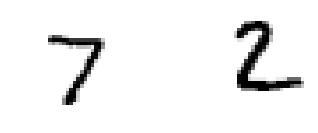

In [75]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Our input node expects to get data with shape (28,28,1) so we need to reshape our two digits.

In [76]:
image_1 = np.expand_dims(x_test[0], axis=2)
image_2 = np.expand_dims(x_test[1], axis=2)

Prepare scoring payload and score.

In [77]:
scoring_data = {'values': [image_1.tolist(), image_2.tolist()]}

In [78]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'fields': ['prediction', 'prediction_classes', 'probability'], 'values': [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 7, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2, [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]}


<a id="summary"></a>
## 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `watson-machine-learning-client` to run experiments. Check out our [Online Documentation](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.